In [314]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
from pylab import *
import scipy.stats as stats
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '../data/endomondoHR_proper.json'
#filename_metadata = './data/endomondoMeta.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")

# Load meta data file into pyspark data frame as well
#df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [298]:
print('Columns & datatypes:')
DataFrame(df.dtypes, columns =['Column Name','Data type'])

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [299]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,167783,167783,167783,167783,167783
1,mean,None,3.614780933983598E8,None,None,4565819.273555724
2,stddev,None,1.571586171633681E8,None,None,3906676.555400663
3,min,female,257936,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674007977,yoga,https://www.endomondo.com/users/9991401/workou...,15481421



Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


In [300]:
print('Summarize on genders:')
gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
gender_activities_count = df.groupBy('gender').count().toPandas()
gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                    , how='inner', lsuffix='_gu')
gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
gender_user_activity_count

Summarize on genders:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1185
1,female,101,9881
2,male,943,156717


# 1) HeatRate difference between different genders and sports

In [385]:
rdd=df.rdd
def avgHeartRate(row):
    if row['heart_rate']!='':
        ht=np.mean(row['heart_rate'])
        return Row(id=int(row['id']), avgHT=float(ht), gender=str(row['gender']),sport=str(row['sport']),userId=row['userId'])
rddaHR=rdd.map(avgHeartRate)
rddaHR.take(3)
df1=spark.createDataFrame(rddaHR)
DataFrame(df1.dtypes, columns =['Column Name','Data type'])

[Row(avgHT=152.65, gender='male', id=396826535, sport='bike', userId=10921915),
 Row(avgHT=147.71, gender='male', id=392337038, sport='bike', userId=10921915),
 Row(avgHT=140.554, gender='male', id=389643739, sport='bike', userId=10921915)]

,Column Name,Data type
0,avgHT,double
1,gender,string
2,id,bigint
3,sport,string
4,userId,bigint


In [302]:
df2=df1.groupBy(['gender','sport']).avg('avgHT')
df2.createOrReplaceTempView("table1")
df2M=spark.sql("SELECT * from table1 where gender='male'")
df2M.toPandas()
df2FM=spark.sql("SELECT * from table1 where gender='female'")
df2FM.toPandas()

,gender,sport,avg(avgHT)
0,male,martial arts,109.044000
1,male,sailing,163.934000
2,male,fitness walking,104.853535
3,male,windsurfing,132.492000
4,male,treadmill walking,186.644000
5,male,aerobics,141.228800
6,male,snowshoeing,127.474727
7,male,elliptical,131.963400
8,male,gymnastics,104.550400
9,male,roller skiing,129.653974


,gender,sport,avg(avgHT)
0,female,mountain bike,142.596029
1,female,run,151.428408
2,female,fitness walking,127.391624
3,female,cross-country skiing,135.610060
4,female,orienteering,155.238818
5,female,kayaking,92.156000
6,female,hiking,114.032450
7,female,bike (transport),131.209013
8,female,snowshoeing,121.362000
9,female,horseback riding,142.704000


In [303]:
df2A=df2M.join(df2FM, 'sport','outer')
df2A.toPandas()

,sport,gender,avg(avgHT),gender,avg(avgHT)
0,weight training,male,107.399738,female,129.021000
1,windsurfing,male,132.492000,None,NaN
2,gymnastics,male,104.550400,female,153.598000
3,mountain bike,male,135.334108,female,142.596029
4,pilates,male,96.287333,None,NaN
5,cross-country skiing,male,138.137305,female,135.610060
6,hiking,male,110.213909,female,114.032450
7,kayaking,male,123.132933,female,92.156000
8,downhill skiing,male,85.424542,None,NaN
9,kite surfing,male,152.434000,None,NaN


In [304]:
df2M=df2M.withColumnRenamed('avg(avgHT)','maleAvg')
df2FM=df2FM.withColumnRenamed('avg(avgHT)','femaleAvg')
df2AInner=df2M.join(df2FM, 'sport','inner')
df2AInner=df2AInner.withColumn('diffAvg',df2AInner.maleAvg-df2AInner.femaleAvg)
df2AInner.toPandas()

,sport,gender,maleAvg,gender,femaleAvg,diffAvg
0,weight training,male,107.399738,female,129.021000,-21.621262
1,gymnastics,male,104.550400,female,153.598000,-49.047600
2,mountain bike,male,135.334108,female,142.596029,-7.261921
3,cross-country skiing,male,138.137305,female,135.610060,2.527246
4,hiking,male,110.213909,female,114.032450,-3.818541
5,kayaking,male,123.132933,female,92.156000,30.976933
6,roller skiing,male,129.653974,female,139.967600,-10.313626
7,circuit training,male,118.425579,female,133.212308,-14.786729
8,fitness walking,male,104.853535,female,127.391624,-22.538089
9,orienteering,male,146.885183,female,155.238818,-8.353635


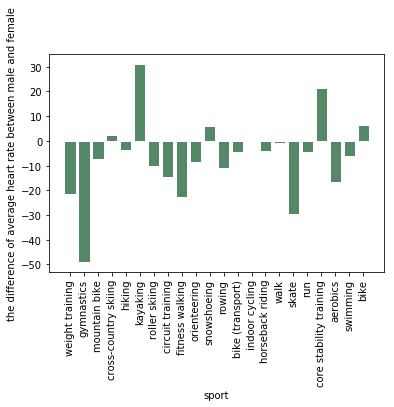

In [595]:
InteractiveShell.ast_node_interactivity = "none"
rddAInner=df2AInner.rdd
sportType=rddAInner.map(lambda row: row['sport']).collect()
diffAvg=rddAInner.map(lambda row: row['diffAvg']).collect()
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('the difference of average heart rate between male and female')
bar(sportType, diffAvg, facecolor='#558866', edgecolor='white')

# 2) The correlation of heatrate and speed, heartrate and altitude

In [382]:
rdd2=df.rdd
def covHeartRate(row):
    if row['heart_rate']!='' and row['speed']!='' and row['altitude']!='':   
        if size(row['heart_rate'])==size(row['speed']) and size(row['heart_rate'])==size(row['altitude']):
            perhtat=stats.pearsonr(row['heart_rate'],row['altitude'])[0]
            perhtsp=stats.pearsonr(row['heart_rate'],row['speed'])[0] 
            abPerhtat=abs(stats.pearsonr(row['heart_rate'],row['altitude'])[0])
            abPerhtsp=abs(stats.pearsonr(row['heart_rate'],row['speed'])[0]) 
            return Row(id=int(row['id']), perhtat=float(perhtat), perhtsp=float(perhtsp), abPerhtat=float(abPerhtat), abPerhtsp=float(abPerhtsp), gender=str(row['gender']), sport=str(row['sport']),userId=row['userId'])
#             return Row(ratiohtsp=float(vecsp))
rddaHR2=rdd2.filter(lambda row: row['speed'] is not None).map(covHeartRate)
df5=spark.createDataFrame(rddaHR2).dropna()
df5.describe().toPandas()

,summary,abPerhtat,abPerhtsp,gender,id,perhtat,perhtsp,sport,userId
0,count,31619,31619,31619,31619,31619,31619,31619,31619
1,mean,0.2740819564531785,0.349513764140059,None,4.0926703876030236E8,0.027003200255308273,0.1896983039418058,None,5246824.048957905
2,stddev,0.197689984651706,0.22459628928652853,None,1.531552854512983E8,0.33686114185183874,0.36962229837024263,None,4202749.049451172
3,min,3.8247149676074963E-16,5.447494646059844E-16,female,9406163,-0.9699399995648301,-0.8858991283273456,bike,2358
4,max,0.9699399995648301,0.9754014117310302,unknown,669263168,0.942730960386833,0.9754014117310302,walk,15326644


In [383]:
df6=df5.groupBy(['gender','sport']).agg({'abPerhtat':'mean','abPerhtsp':'mean'})
df6.createOrReplaceTempView("table3")
df6M=spark.sql("SELECT * from table3 where gender='male'")
df6M=df6M.withColumnRenamed('avg(abPerhtat)','mAvgPerhtat').withColumnRenamed('avg(abPerhtsp)','mAvgPerhtsp')
df6M.toPandas()
df6FM=spark.sql("SELECT * from table3 where gender='female'")
df6FM=df6FM.withColumnRenamed('avg(abPerhtat)','fmAvgPerhtat').withColumnRenamed('avg(abPerhtsp)','fmAvgPerhtsp')
df6FM.toPandas()

,gender,sport,mAvgPerhtsp,mAvgPerhtat
0,male,fitness walking,0.398399,0.297474
1,male,roller skiing,0.309080,0.196715
2,male,bike (transport),0.326295,0.263384
3,male,kayaking,0.327470,0.180076
4,male,run,0.366133,0.283926
5,male,bike,0.342324,0.267588
6,male,orienteering,0.333226,0.217537
7,male,cross-country skiing,0.198239,0.326234
8,male,hiking,0.307802,0.351836
9,male,skate,0.449483,0.135692


,gender,sport,fmAvgPerhtsp,fmAvgPerhtat
0,female,mountain bike,0.136664,0.169885
1,female,run,0.297339,0.270254
2,female,fitness walking,0.141078,0.193166
3,female,cross-country skiing,0.341364,0.141074
4,female,bike (transport),0.247951,0.187499
5,female,bike,0.288563,0.228935
6,female,indoor cycling,0.207275,0.250962
7,female,walk,0.226628,0.243692
8,female,core stability training,0.082343,0.473539
9,female,skate,0.225395,0.261445


/home/feifei/.conda/envs/bigdata-lab/lib/python3.5/site-packages/pyspark/sql/session.py:346: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


The average correlation coefficient of different sports for male and female
             correlation  gender      mean  variance
0  (heartrate, altitude)    male  0.252697  0.005419
1     (heartrate, speed)    male  0.355373  0.009346
2  (heartrate, altitude)  female  0.242045  0.007578
3     (heartrate, speed)  female  0.219460  0.005855


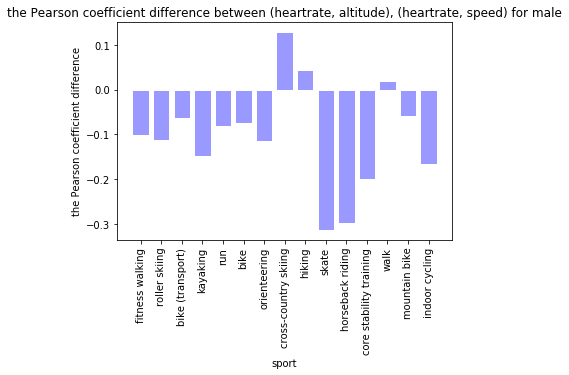

In [594]:
InteractiveShell.ast_node_interactivity = "none"

rdd6MInner=df6M.rdd
rdd6FMInner=df6FM.rdd
sportTypeM=rdd6MInner.map(lambda row: row['sport']).collect()
sportTypeFM=rdd6FMInner.map(lambda row: row['sport']).collect()
perMhtat=rdd6MInner.map(lambda row: row['mAvgPerhtat']).collect()
perMhtsp=rdd6MInner.map(lambda row: row['mAvgPerhtsp']).collect()
perFMhtat=rdd6FMInner.map(lambda row: row['fmAvgPerhtat']).collect()
perFMhtsp=rdd6FMInner.map(lambda row: row['fmAvgPerhtsp']).collect()

meanMhtat=mean(perMhtat)
varMhtat=var(perMhtat)
meanMhtsp=mean(perMhtsp)
varMhtsp=var(perMhtsp)
meanFMhtat=mean(perFMhtat)
varFMhtat=var(perFMhtat)
meanFMhtsp=mean(perFMhtsp)
varFMhtsp=var(perFMhtsp)
lis=[{'gender':'male', 'correlation':'(heartrate, altitude)','mean': float(meanMhtat), 'variance': float(varMhtat)}, {'gender':'male','correlation':'(heartrate, speed)','mean': float(meanMhtsp), 'variance': float(varMhtsp) },
     {'gender':'female', 'correlation':'(heartrate, altitude)','mean': float(meanFMhtat), 'variance': float(varFMhtat)}, {'gender':'female', 'correlation':'(heartrate, speed)','mean': float(meanFMhtsp), 'variance': float(varFMhtsp)}]
showdf6=spark.createDataFrame(lis)
print("The average correlation coefficient of different sports for male and female")
print(showdf6.toPandas())


diffMatsp=np.array(perMhtat)-np.array(perMhtsp)
diffFMatsp=np.array(perFMhtat)-np.array(perFMhtsp)
# plt.xticks(rotation=90)
# plt.xlabel('sport')
# plt.ylabel('Pearson coefficient')
# plt.title('Figure 1 Pearson coefficient of (heartrate, altitude), (heartrate, speed) for Male')
# plt.plot(sportTypeM,perMhtat,color='lightgreen',label='ratioMVarhtat')
# plt.plot(sportTypeM,perMhtsp,color='forestgreen', linestyle='-.', label='ratioFMVarhtat')
# plt.figure(figsize=(6,9)) #调节图形大小
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('the Pearson coefficient difference')
plt.title('the Pearson coefficient difference between (heartrate, altitude), (heartrate, speed) for male')
bar(sportTypeM, diffMatsp, facecolor='#9999ff', edgecolor='white')

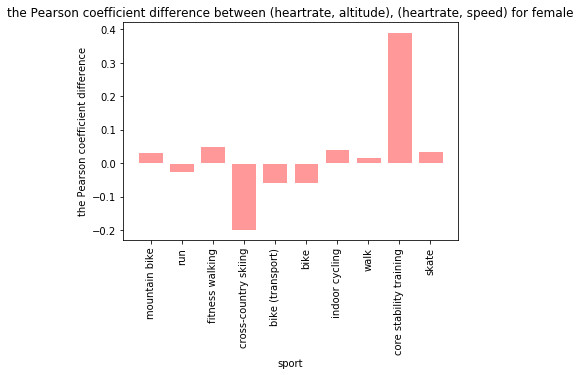

In [591]:
InteractiveShell.ast_node_interactivity = "all"
plt.xticks(rotation=90)
plt.xlabel('sport')
plt.ylabel('the Pearson coefficient difference')
plt.title('the Pearson coefficient difference between (heartrate, altitude), (heartrate, speed) for female')
bar(sportTypeFM, diffFMatsp, facecolor='#ff9999', edgecolor='white')

# 3) The popular choice of sports for male and female to start during different period of a day

In [500]:
from datetime import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

rdd3=df.rdd
def sameday(row):
    if row['heart_rate']!='' and row['speed']!='' and row['altitude']!='':   
        if size(row['heart_rate'])==size(row['speed']) and size(row['heart_rate'])==size(row['altitude']):
            dateValue=[datetime.fromtimestamp(t) for t in row['timestamp']]
#             if dateValue[0].year == dateValue[2].year and dateValue[0].month == dateValue[2].month and dateValue[0].date == dateValue[2].date:
            return Row(id=int(row['id']), gender=row['gender'], timestamp=row['timestamp'], heartrate=row['heart_rate'], speed=row['speed'], altitude=row['altitude'], year=dateValue[0].year, month=dateValue[0].month, day=dateValue[0].day, yearl=dateValue[-1].year, monthl=dateValue[-1].month, dayl=dateValue[-1].day, sport=str(row['sport']),userId=row['userId'])
#             return Row(ratiohtsp=float(vecsp))
rddaHR3=rdd3.filter(lambda row: row['speed'] is not None).map(sameday).filter(lambda row: row['year']==row['yearl'] and row['month']==row['monthl'] and row['day']==row['dayl'])
df7=spark.createDataFrame(rddaHR3).drop('year').drop('yearl').drop('month').drop('day').drop('monthl').drop('dayl')
# DataFrame(df7.dtypes, columns =['Column Name','Data type'])
# df7.describe().toPandas()
def markWorkout(row):
    hours=[datetime.fromtimestamp(t).hour for t in row['timestamp']]
    mark=-1
    upIndex=-1
    if hours[0]>=6 and hours[0]<12:
        upIndex=[i for i in range(len(hours)) if hours[i]<12][-1]
        mark=1
    elif hours[0]>=12 and hours[0]<18:
        upIndex=[i for i in range(len(hours)) if hours[i]<19][-1]
        mark=2
    elif hours[0]>=18 and hours[0]<24:
        upIndex=[i for i in range(len(hours)) if hours[i]<24][-1]
        mark=3
    elif hours[0]>=0 and hours[0]<6:
        upIndex=[i for i in range(len(hours)) if hours[i]<8][-1]
        mark=0
    if mark!=-1 and upIndex!=-1:
        reTimestamp=row['timestamp'][:upIndex]
        dateValue=[datetime.fromtimestamp(t) for t in reTimestamp]
        reHeartRate=row['heartrate'][:upIndex]
        reAltitude=row['altitude'][:upIndex]
        reSpeed=row['speed'][:upIndex]
        count=upIndex+1
        return Row(id=row['id'], gender=row['gender'], mark=mark, countTimestamp=count, reTimestamp=reTimestamp, dateValue=dateValue, reHeartRate=reHeartRate, reAltitude=reAltitude, reSpeed=reSpeed, sport=str(row['sport']),userId=row['userId'])
    
rdd31=df7.rdd.map(markWorkout).filter(lambda row: row['countTimestamp']>10)
df8=spark.createDataFrame(rdd31)
DataFrame(df8.dtypes, columns =['Column Name','Data type'])
df8.describe().toPandas()
df8.limit(3).toPandas()

,Column Name,Data type
0,countTimestamp,bigint
1,dateValue,array<timestamp>
2,gender,string
3,id,bigint
4,mark,bigint
5,reAltitude,array<double>
6,reHeartRate,array<bigint>
7,reSpeed,array<double>
8,reTimestamp,array<bigint>
9,sport,string


,summary,countTimestamp,gender,id,mark,sport,userId
0,count,31042,31042,31042,31042,31042,31042
1,mean,468.23803234327687,None,4.096449976874879E8,1.7316216738612202,None,5242912.461020553
2,stddev,93.37010627715453,None,1.5294279770419806E8,0.9892163671974585,None,4210463.117310324
3,min,11,female,9406163,0,bike,2358
4,max,500,unknown,669263168,3,walk,15326644


,countTimestamp,dateValue,gender,id,mark,reAltitude,reHeartRate,reSpeed,reTimestamp,sport,userId
0,500,"[2014-08-24 12:45:46, 2014-08-24 12:45:54, 201...",male,396826535,2,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[100, 111, 120, 119, 120, 116, 125, 128, 131, ...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...","[1408898746, 1408898754, 1408898765, 140889877...",bike,10921915
1,500,"[2014-08-16 16:41:22, 2014-08-16 16:41:27, 201...",male,392337038,2,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[100, 105, 111, 110, 108, 115, 126, 130, 132, ...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...","[1408221682, 1408221687, 1408221699, 140822170...",bike,10921915
2,51,"[2014-08-12 11:47:39, 2014-08-12 11:47:46, 201...",male,389643739,1,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...","[1407858459, 1407858466, 1407858478, 140785849...",bike,10921915


In [547]:
df8Count=df8.groupBy(['mark','sport','gender']).count().orderBy(['mark','sport','gender'])
rdd8Count=df8Count.rdd
df8Count.createOrReplaceTempView("table4")
df8CountM=spark.sql("SELECT * from table4 where gender='male'")
df8CountM.toPandas()
df8CountFM=spark.sql("SELECT * from table4 where gender='female'")
df8CountFM.toPandas()

sportTypeM0=rdd8Count.filter(lambda row: row['mark']==0 and row['gender']=='male').map(lambda row: row['sport']).collect()
sportTypeFM0=rdd8Count.filter(lambda row: row['mark']==0 and row['gender']=='female').map(lambda row: row['sport']).collect()
countM0=rdd8Count.filter(lambda row: row['mark']==0 and row['gender']=='male').map(lambda row: row['count']).collect()
countFM0=rdd8Count.filter(lambda row: row['mark']==0 and row['gender']=='female').map(lambda row: row['count']).collect()

sportTypeM1=rdd8Count.filter(lambda row: row['mark']==1 and row['gender']=='male').map(lambda row: row['sport']).collect()
sportTypeFM1=rdd8Count.filter(lambda row: row['mark']==1 and row['gender']=='female').map(lambda row: row['sport']).collect()
countM1=rdd8Count.filter(lambda row: row['mark']==1 and row['gender']=='male').map(lambda row: row['count']).collect()
countFM1=rdd8Count.filter(lambda row: row['mark']==1 and row['gender']=='female').map(lambda row: row['count']).collect()

sportTypeM2=rdd8Count.filter(lambda row: row['mark']==2 and row['gender']=='male').map(lambda row: row['sport']).collect()
sportTypeFM2=rdd8Count.filter(lambda row: row['mark']==2 and row['gender']=='female').map(lambda row: row['sport']).collect()
countM2=rdd8Count.filter(lambda row: row['mark']==2 and row['gender']=='male').map(lambda row: row['count']).collect()
countFM2=rdd8Count.filter(lambda row: row['mark']==2 and row['gender']=='female').map(lambda row: row['count']).collect()

sportTypeM3=rdd8Count.filter(lambda row: row['mark']==3 and row['gender']=='male').map(lambda row: row['sport']).collect()
sportTypeFM3=rdd8Count.filter(lambda row: row['mark']==3 and row['gender']=='female').map(lambda row: row['sport']).collect()
countM3=rdd8Count.filter(lambda row: row['mark']==3 and row['gender']=='male').map(lambda row: row['count']).collect()
countFM3=rdd8Count.filter(lambda row: row['mark']==3 and row['gender']=='female').map(lambda row: row['count']).collect()

,mark,sport,gender,count
0,0,bike,male,2998
1,0,bike (transport),male,115
2,0,core stability training,male,1
3,0,indoor cycling,male,264
4,0,mountain bike,male,21
5,0,run,male,757
6,0,walk,male,16
7,1,bike,male,3796
8,1,bike (transport),male,307
9,1,core stability training,male,4


,mark,sport,gender,count
0,0,bike,female,97
1,0,bike (transport),female,14
2,0,indoor cycling,female,37
3,0,run,female,8
4,1,bike,female,90
5,1,bike (transport),female,10
6,1,core stability training,female,2
7,1,cross-country skiing,female,1
8,1,fitness walking,female,4
9,1,indoor cycling,female,1


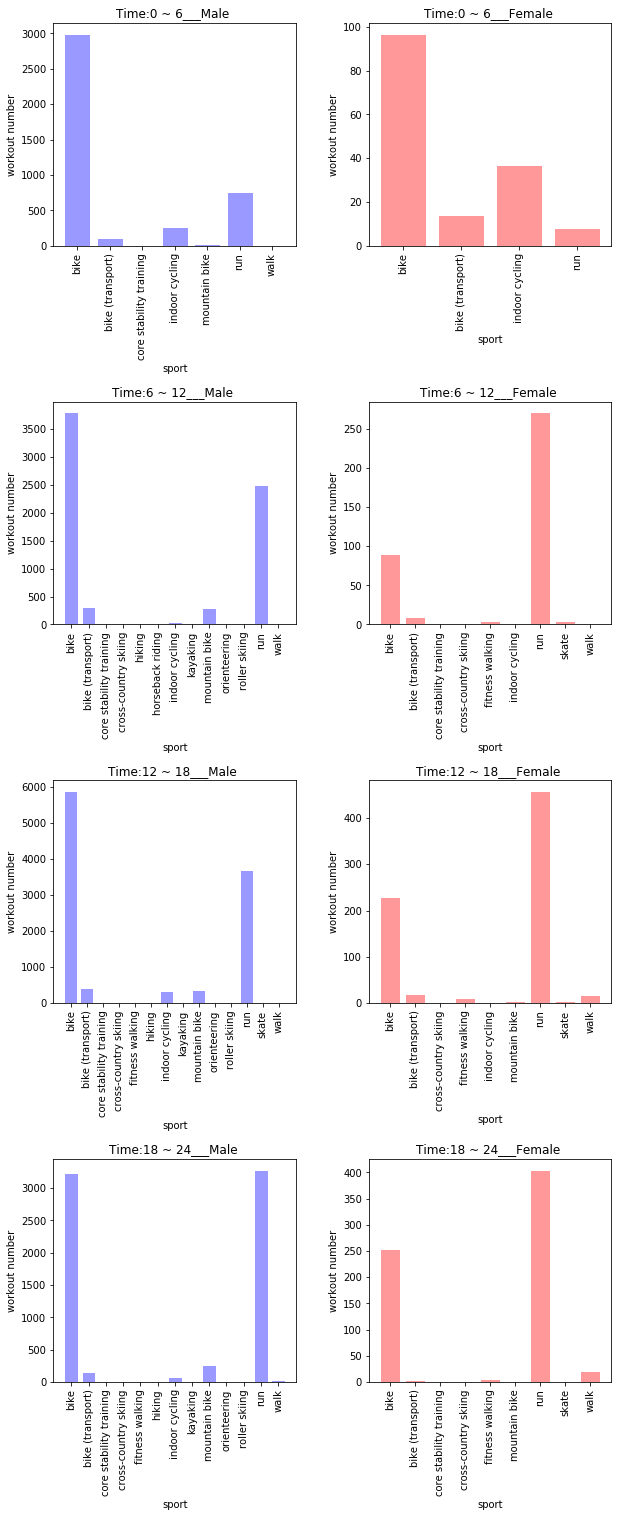

In [590]:
InteractiveShell.ast_node_interactivity = "none"
fig,axes=plt.subplots(4,2,figsize=(10,25))
plt.subplots_adjust(wspace =0.3, hspace =0.7)

for i in range(8):
    ax=plt.subplot(4,2,i+1)
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.xlabel('sport')
    plt.ylabel('workout number')
    if i%2==0:
        plt.title('Time:'+str(int(i/2*6))+' ~ ' + str(int(i/2*6)+6) +'___Male ')
        sportType=locals()['sportTypeM'+str(int(i/2))]
        count=locals()['countM'+str(int(i/2))]
        facecolor='#9999ff'
        bar(sportType, count, facecolor=facecolor, edgecolor='white')
    else:
        plt.title('Time:'+str(int((i-1)/2*6))+' ~ ' + str(int((i-1)/2*6)+6) +'___Female ')
        sportType=locals()['sportTypeFM'+str(int(i/2))]
        count=locals()['countFM'+str(int(i/2))]
        facecolor='#ff9999'
        bar(sportType, count, facecolor=facecolor, edgecolor='white')


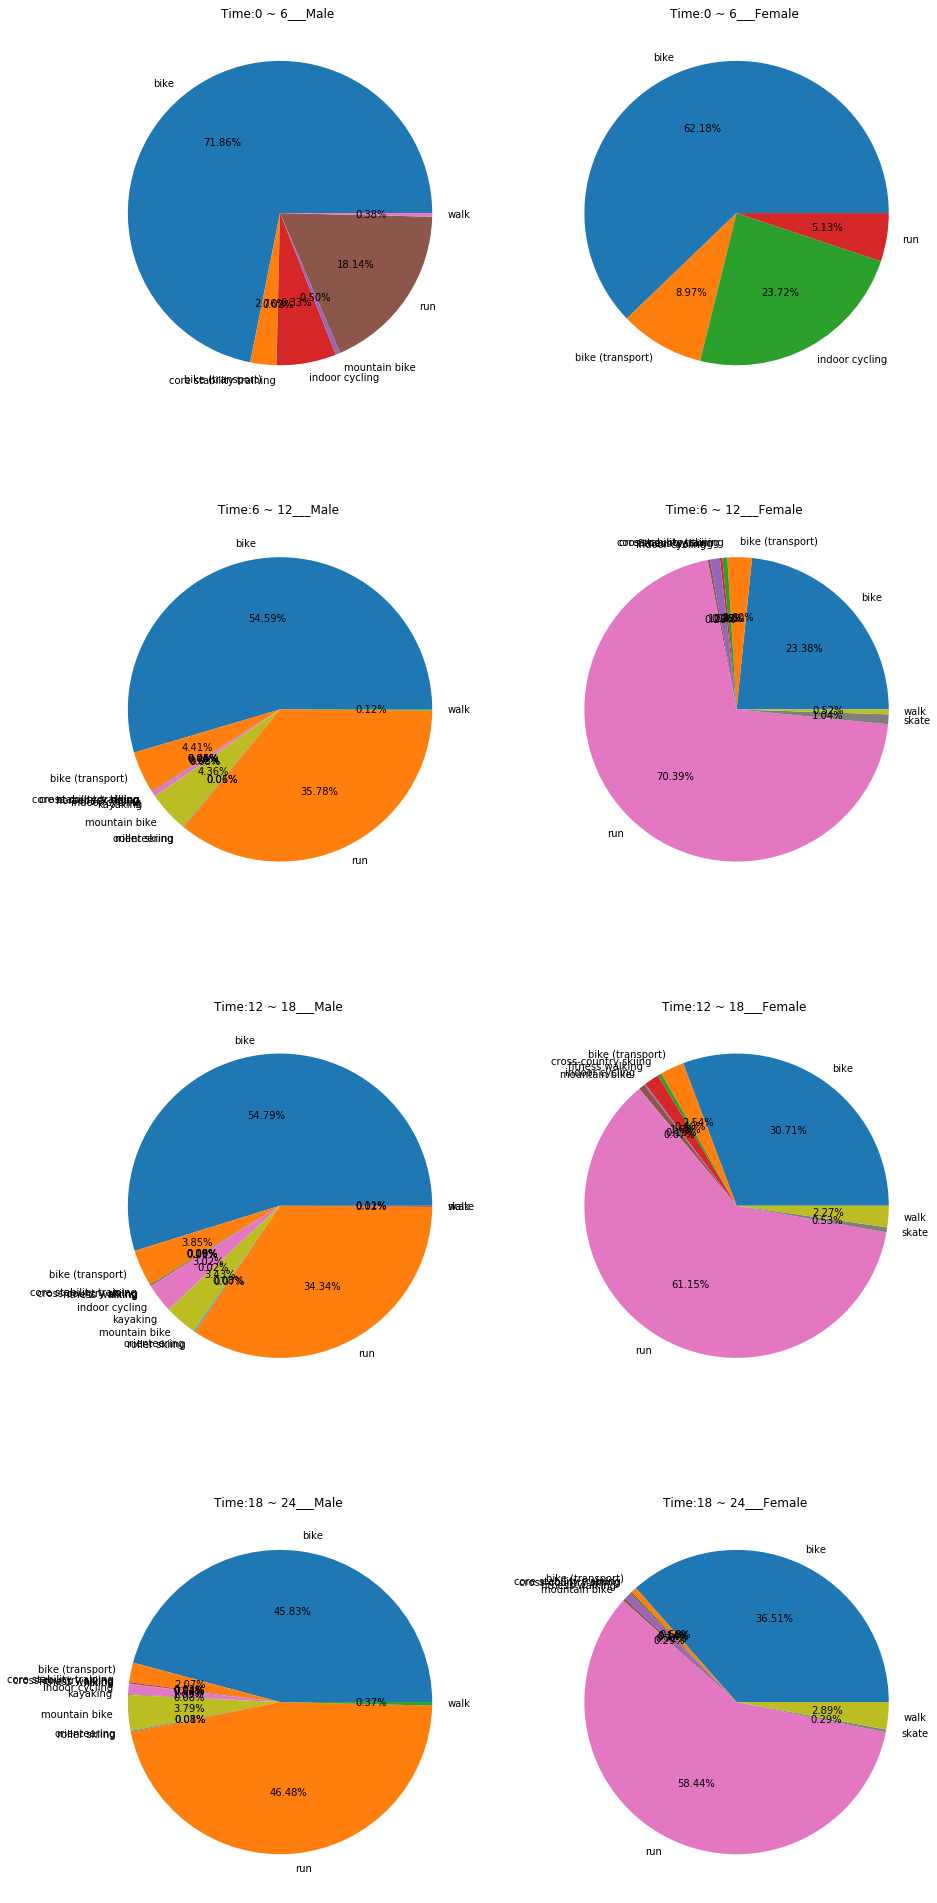

In [589]:
InteractiveShell.ast_node_interactivity = "none"
fig,axes=plt.subplots(4,2,figsize=(15,35))

for i in range(8):
    ax=plt.subplot(4,2,i+1)
    plt.sca(ax)
    if i%2==0:
        plt.title('Time:'+str(int(i/2*6))+' ~ ' + str(int(i/2*6)+6) +'___Male ')
        sportType=locals()['sportTypeM'+str(int(i/2))]
        count=locals()['countM'+str(int(i/2))]
        facecolor='#9999ff'
        plt.pie(x=count, autopct='%.2f%%', labels=sportType)
    else:
        plt.title('Time:'+str(int((i-1)/2*6))+' ~ ' + str(int((i-1)/2*6)+6) +'___Female ')
        sportType=locals()['sportTypeFM'+str(int(i/2))]
        count=locals()['countFM'+str(int(i/2))]
        facecolor='#ff9999'
        plt.pie(x=count, labels=sportType, autopct='%.2f%%')
        

# fig = plt.figure()
# plt.pie(X,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
# plt.title("Pie chart")

# 4) Average heartrate, altitude, speed change for each sport during different period

In [598]:
InteractiveShell.ast_node_interactivity = "all"
rdd8=df8.rdd
def avgReHeartRate(row):
    if row['reHeartRate']!='':
        reAvgHeartRate=np.mean(row['reHeartRate'])
        reVarHeartRate=np.var(row['reHeartRate'])
        reAvgAltitude=np.mean(row['reAltitude'])
        reVarAltitude=np.var(row['reAltitude'])
        reAvgSpeed=np.mean(row['reSpeed'])
        reVarSpeed=np.var(row['reSpeed'])
        return Row(id=int(row['id']), mark=row['mark'], reAvgHeartRate=float(reAvgHeartRate), reVarHeartRate=float(reVarHeartRate), reAvgAltitude=float(reAvgAltitude), reVarAltitude=float(reVarAltitude), reAvgSpeed=float(reAvgSpeed), reVarSpeed=float(reVarSpeed), gender=str(row['gender']),sport=str(row['sport']),userId=row['userId'])
rdda8HR=rdd8.map(avgReHeartRate)
# rdda8HR.take(3)
df9=spark.createDataFrame(rdda8HR)
DataFrame(df9.dtypes, columns =['Column Name','Data type'])


df9AvgHearRate=df9.groupBy(['mark','sport','gender']).avg('reAvgHeartRate', 'reVarHeartRate', 'reAvgAltitude', 'reVarAltitude', 'reAvgSpeed', 'reVarSpeed').orderBy(['mark','sport','gender'])
df9AvgHearRate.toPandas()

[Row(gender='male', id=396826535, mark=2, reAvgAltitude=43.08496993987976, reAvgHeartRate=152.65330661322645, reAvgSpeed=26.206852905811623, reVarAltitude=181.8690125742467, reVarHeartRate=104.85174758334304, reVarSpeed=66.46760424441541, sport='bike', userId=10921915),
 Row(gender='male', id=392337038, mark=2, reAvgAltitude=35.726252505010024, reAvgHeartRate=147.7074148296593, reAvgSpeed=27.256718236472945, reVarAltitude=107.87736691820515, reVarHeartRate=120.57972457941936, reVarSpeed=66.22697902850511, sport='bike', userId=10921915),
 Row(gender='male', id=389643739, mark=1, reAvgAltitude=65.344, reAvgHeartRate=128.06, reAvgSpeed=25.404623999999995, reVarAltitude=18.88486400000001, reVarHeartRate=123.0564, reVarSpeed=32.944301005823995, sport='bike', userId=10921915)]

,Column Name,Data type
0,gender,string
1,id,bigint
2,mark,bigint
3,reAvgAltitude,double
4,reAvgHeartRate,double
5,reAvgSpeed,double
6,reVarAltitude,double
7,reVarHeartRate,double
8,reVarSpeed,double
9,sport,string


,mark,sport,gender,avg(reAvgHeartRate),avg(reVarHeartRate),avg(reAvgAltitude),avg(reVarAltitude),avg(reAvgSpeed),avg(reVarSpeed)
0,0,bike,female,135.111791,345.370072,142.842915,112.402973,24.779044,42.276187
1,0,bike,male,134.189442,202.958250,90.972383,2987.301236,27.104850,46.919782
2,0,bike,unknown,151.899752,184.775314,34.629974,219.315193,30.922072,58.210274
3,0,bike (transport),female,145.110793,324.607890,50.745262,449.524935,21.756083,64.175248
4,0,bike (transport),male,134.796724,180.655704,85.024689,290.945508,23.900880,42.674506
5,0,core stability training,male,160.286573,142.304649,538.031663,6.040921,12.259840,3.622825
6,0,indoor cycling,female,133.494069,255.663443,24.990847,313.971111,26.315033,155.243541
7,0,indoor cycling,male,131.063361,195.091470,36.480641,269.514320,27.021452,20.236370
8,0,mountain bike,male,136.438366,220.624500,146.845294,1481.023070,17.667172,39.654452
9,0,run,female,155.650050,176.763719,169.157064,184.449196,10.214324,3.130112


In [667]:
InteractiveShell.ast_node_interactivity = "all"
rdd9AvgHearRate=df9AvgHearRate.rdd
rddtimeM0=rdd9AvgHearRate.filter(lambda row: row['mark']==0 and row['gender']=='male')
rddtimeM1=rdd9AvgHearRate.filter(lambda row: row['mark']==1 and row['gender']=='male')
rddtimeM2=rdd9AvgHearRate.filter(lambda row: row['mark']==2 and row['gender']=='male')
rddtimeM3=rdd9AvgHearRate.filter(lambda row: row['mark']==3 and row['gender']=='male')
rddtimeFM0=rdd9AvgHearRate.filter(lambda row: row['mark']==0 and row['gender']=='female')
rddtimeFM1=rdd9AvgHearRate.filter(lambda row: row['mark']==1 and row['gender']=='female')
rddtimeFM2=rdd9AvgHearRate.filter(lambda row: row['mark']==2 and row['gender']=='female')
rddtimeFM3=rdd9AvgHearRate.filter(lambda row: row['mark']==3 and row['gender']=='female')

dftimeM0=spark.createDataFrame(rddtimeM0).withColumnRenamed('avg(reAvgHeartRate)','MreAvgSptAvgHeartRate0').withColumnRenamed('avg(reVarHeartRate)','MreAvgSptVarHeartRate0').withColumnRenamed('avg(reAvgAltitude)','MreAvgSptAvgAltitude0').withColumnRenamed('avg(reVarAltitude)','MreAvgSptVarAltitude0').withColumnRenamed('avg(reAvgSpeed)','MreAvgSptAvgSpeed0').withColumnRenamed('avg(reVarSpeed)','MreAvgSptVarSpeed0')
dftimeM1=spark.createDataFrame(rddtimeM1).withColumnRenamed('avg(reAvgHeartRate)','MreAvgSptAvgHeartRate1').withColumnRenamed('avg(reVarHeartRate)','MreAvgSptVarHeartRate1').withColumnRenamed('avg(reAvgAltitude)','MreAvgSptAvgAltitude1').withColumnRenamed('avg(reVarAltitude)','MreAvgSptVarAltitude1').withColumnRenamed('avg(reAvgSpeed)','MreAvgSptAvgSpeed1').withColumnRenamed('avg(reVarSpeed)','MreAvgSptVarSpeed1')
dftimeM2=spark.createDataFrame(rddtimeM2).withColumnRenamed('avg(reAvgHeartRate)','MreAvgSptAvgHeartRate2').withColumnRenamed('avg(reVarHeartRate)','MreAvgSptVarHeartRate2').withColumnRenamed('avg(reAvgAltitude)','MreAvgSptAvgAltitude2').withColumnRenamed('avg(reVarAltitude)','MreAvgSptVarAltitude2').withColumnRenamed('avg(reAvgSpeed)','MreAvgSptAvgSpeed2').withColumnRenamed('avg(reVarSpeed)','MreAvgSptVarSpeed2')
dftimeM3=spark.createDataFrame(rddtimeM3).withColumnRenamed('avg(reAvgHeartRate)','MreAvgSptAvgHeartRate3').withColumnRenamed('avg(reVarHeartRate)','MreAvgSptVarHeartRate3').withColumnRenamed('avg(reAvgAltitude)','MreAvgSptAvgAltitude3').withColumnRenamed('avg(reVarAltitude)','MreAvgSptVarAltitude3').withColumnRenamed('avg(reAvgSpeed)','MreAvgSptAvgSpeed3').withColumnRenamed('avg(reVarSpeed)','MreAvgSptVarSpeed3')
dftimeFM0=spark.createDataFrame(rddtimeFM0).withColumnRenamed('avg(reAvgHeartRate)','FMreAvgSptAvgHeartRate0').withColumnRenamed('avg(reVarHeartRate)','FMreAvgSptVarHeartRate0').withColumnRenamed('avg(reAvgAltitude)','FMreAvgSptAvgAltitude0').withColumnRenamed('avg(reVarAltitude)','FMreAvgSptVarAltitude0').withColumnRenamed('avg(reAvgSpeed)','FMreAvgSptAvgSpeed0').withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed0')
dftimeFM1=spark.createDataFrame(rddtimeFM1).withColumnRenamed('avg(reAvgHeartRate)','FMreAvgSptAvgHeartRate1').withColumnRenamed('avg(reVarHeartRate)','FMreAvgSptVarHeartRate1').withColumnRenamed('avg(reAvgAltitude)','FMreAvgSptAvgAltitude1').withColumnRenamed('avg(reVarAltitude)','FMreAvgSptVarAltitude1').withColumnRenamed('avg(reAvgSpeed)','FMreAvgSptAvgSpeed1').withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed1')
dftimeFM2=spark.createDataFrame(rddtimeFM2).withColumnRenamed('avg(reAvgHeartRate)','FMreAvgSptAvgHeartRate2').withColumnRenamed('avg(reVarHeartRate)','FMreAvgSptVarHeartRate2').withColumnRenamed('avg(reAvgAltitude)','FMreAvgSptAvgAltitude2').withColumnRenamed('avg(reVarAltitude)','FMreAvgSptVarAltitude2').withColumnRenamed('avg(reAvgSpeed)','FMreAvgSptAvgSpeed2').withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed2')
dftimeFM3=spark.createDataFrame(rddtimeFM3).withColumnRenamed('avg(reAvgHeartRate)','FMreAvgSptAvgHeartRate3').withColumnRenamed('avg(reVarHeartRate)','FMreAvgSptVarHeartRate3').withColumnRenamed('avg(reAvgAltitude)','FMreAvgSptAvgAltitude3').withColumnRenamed('avg(reVarAltitude)','FMreAvgSptVarAltitude3').withColumnRenamed('avg(reAvgSpeed)','FMreAvgSptAvgSpeed3').withColumnRenamed('avg(reVarSpeed)','FMreAvgSptVarSpeed3')
dftimeMAll=dftimeM0.join(dftimeM1, 'sport', 'outer').join(dftimeM2, 'sport', 'outer').join(dftimeM3, 'sport', 'outer')
dftimeMAll.toPandas()
dftimeFMAll=dftimeFM0.join(dftimeFM1, 'sport', 'outer').join(dftimeFM2, 'sport', 'outer').join(dftimeFM3, 'sport', 'outer')
dftimeFMAll.toPandas()

,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,mountain bike,0.0,male,136.438366,220.624500,146.845294,1481.023070,17.667172,39.654452,1.0,...,20.008959,59.327214,3.0,male,138.167656,253.722345,149.006188,1720.432118,20.725960,58.109141
1,cross-country skiing,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,14.743672,19.127987,3.0,male,149.811623,149.738305,111.110180,119.856930,13.988515,15.509797
2,hiking,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.445680,0.764849,3.0,male,114.490982,156.712688,296.858517,1283.856593,6.677491,3.819036
3,kayaking,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,11.779077,2.309286,3.0,male,112.529392,71.367823,4.114963,8.564702,8.364712,1.034665
4,roller skiing,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,17.222779,16.160333,3.0,male,126.624582,136.273285,16.407749,62.758414,14.515425,5.205938
5,fitness walking,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.504801,3.670794,3.0,male,112.418170,172.001398,189.880561,106.712104,13.266192,14.313988
6,orienteering,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.635251,3.195736,3.0,male,134.531062,46.429396,44.930661,370.201605,9.536321,6.304085
7,bike (transport),0.0,male,134.796724,180.655704,85.024689,290.945508,23.900880,42.674506,1.0,...,23.470366,36.202744,3.0,male,127.741236,159.809658,54.376276,240.357639,23.982064,36.204825
8,indoor cycling,0.0,male,131.063361,195.091470,36.480641,269.514320,27.021452,20.236370,1.0,...,28.448895,35.098147,3.0,male,141.357038,251.505137,76.268743,83.148655,25.017386,51.640025
9,horseback riding,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,mountain bike,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.477030,45.537010,3.0,female,165.479960,108.269923,13.994589,18.175079,17.143792,41.202769
1,cross-country skiing,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,14.869445,71.315229,3.0,female,130.953908,155.158196,395.993587,748.632263,10.655509,38.614658
2,fitness walking,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.271982,2.135982,3.0,female,126.038878,188.853407,21.809619,691.207219,7.261597,3.208660
3,bike (transport),0.0,female,145.110793,324.607890,50.745262,449.524935,21.756083,64.175248,1.0,...,20.114830,26.298178,3.0,female,143.413327,136.617224,27.369339,203.716056,21.326349,45.886470
4,indoor cycling,0.0,female,133.494069,255.663443,24.990847,313.971111,26.315033,155.243541,1.0,...,0.013794,0.032122,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
5,walk,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,6.394235,4.277855,3.0,female,94.791182,74.704781,56.523347,49.115453,6.123798,1.135956
6,skate,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,17.320783,10.629314,3.0,female,148.972946,232.559958,302.585772,12.426609,18.828830,14.037213
7,run,0.0,female,155.650050,176.763719,169.157064,184.449196,10.214324,3.130112,1.0,...,10.294138,2.863437,3.0,female,149.802454,127.865947,86.915434,167.993869,9.725666,2.953134
8,core stability training,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,3.0,female,91.725451,135.770314,52.327054,16.482374,5.951543,0.380574
9,bike,0.0,female,135.111791,345.370072,142.842915,112.402973,24.779044,42.276187,1.0,...,24.478024,42.377820,3.0,female,133.638312,205.852392,55.626678,424.095552,24.412566,42.094547


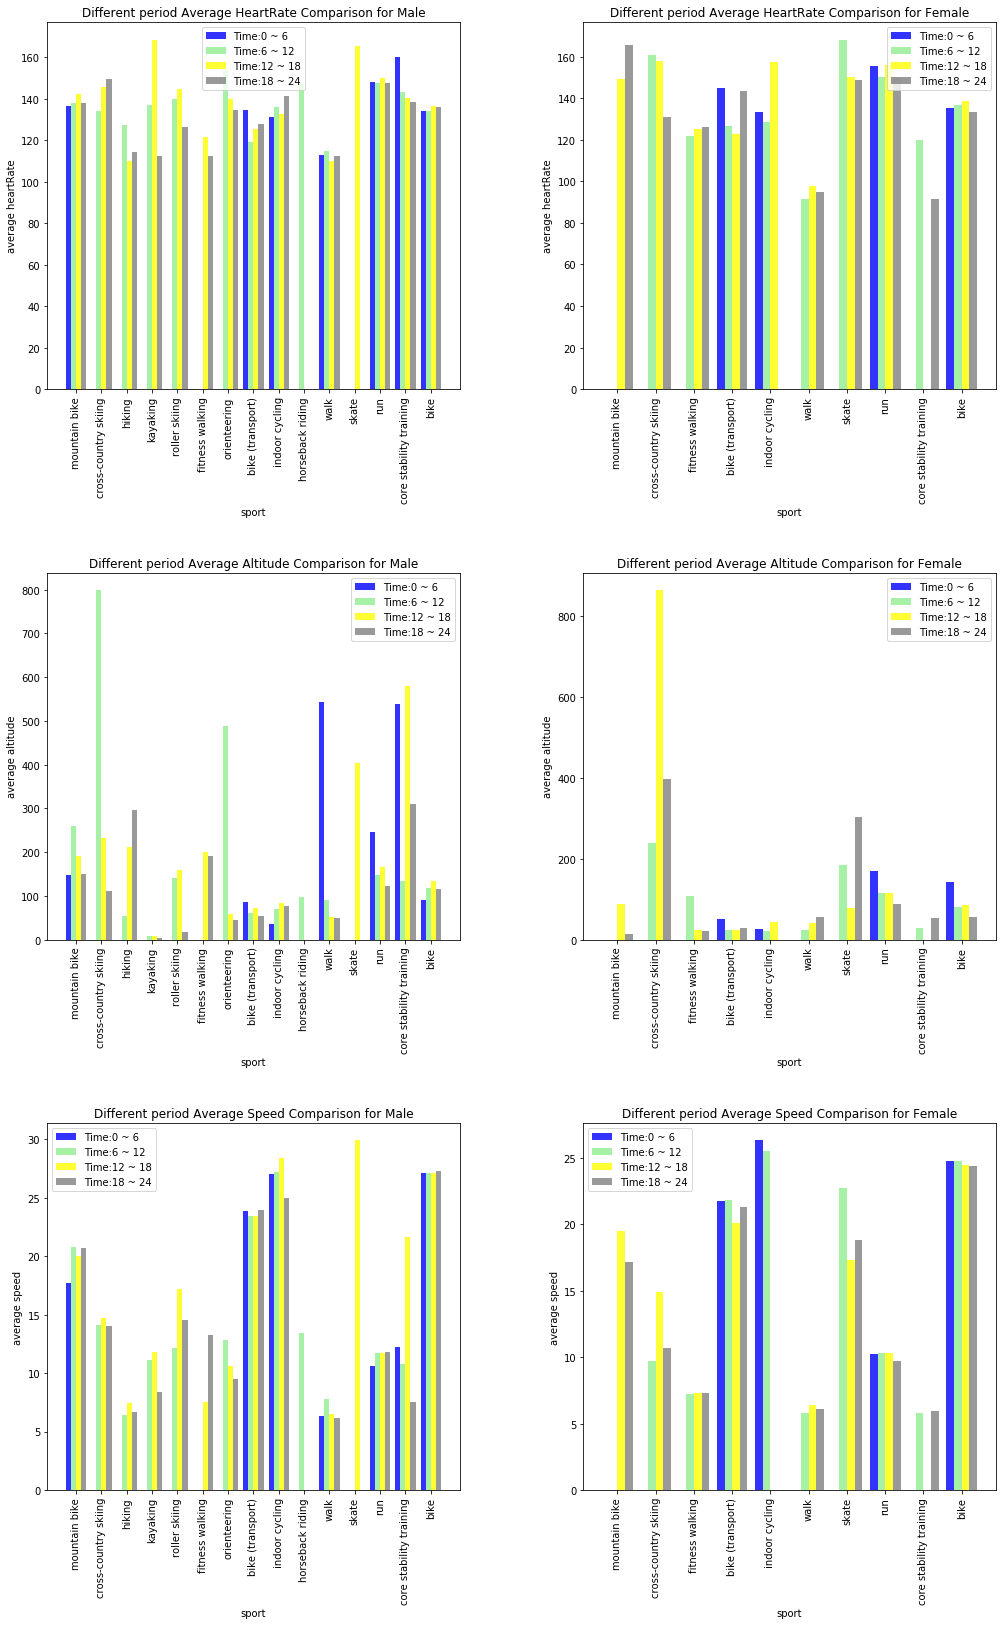

In [707]:
InteractiveShell.ast_node_interactivity = "none"

fig,axes=plt.subplots(3,2,figsize=(17,27))
plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width=0.2
color=['blue','lightgreen','yellow','grey']
        
for j in range(6):
    ax=plt.subplot(3,2,j+1)
    plt.sca(ax)
    if int(j/2)==1:
        nameStr1='reAvgSptAvgAltitude'
        nameStr3='Altitude'
        nameStr5='altitude'
    elif int(j/2)==2:
        nameStr1='reAvgSptAvgSpeed'
        nameStr3='Speed'
        nameStr5='speed'
    elif int(j/2)==0:
        nameStr1='reAvgSptAvgHeartRate'
        nameStr3='HeartRate'
        nameStr5='heartRate'        
    if j%2==0:
        nameStr2='M'
        nameStr4='Male'
    else:
        nameStr2='FM'
        nameStr4='Female'
    dftimeAll=locals()['dftime'+nameStr2+'All']
    dftimeAllSportType=dftimeAll.rdd.map(lambda row: row['sport']).collect() 
    for k in range(4):
        rowName=nameStr2+nameStr1+str(k)
        dfTimeLi=dftimeAll.rdd.map(lambda row: row[rowName]).collect()
        dfTimeLi=[0 if i==None else i for i in dfTimeLi ]
        plt.bar(x=np.arange(len(dftimeAllSportType))+k*bar_width, height=dfTimeLi, label='Time:'+str(int(k*6))+' ~ ' + str(int(k*6)+6), color=color[k], alpha=0.8, width=bar_width)
    plt.xticks(np.arange(len(dftimeAllSportType))+1.5*bar_width, dftimeAllSportType, rotation=90)
    plt.title("Different period Average "+ nameStr3 +" Comparison for "+nameStr4)
    plt.legend()
    plt.xlabel("sport")
    plt.ylabel("average "+nameStr5)


In [712]:
InteractiveShell.ast_node_interactivity = "all"
dftimeMIN=dftimeM0.join(dftimeM1, 'sport', 'inner').join(dftimeM2, 'sport', 'inner').join(dftimeM3, 'sport', 'inner')
dftimeMIN.toPandas()
dftimeFMIN=dftimeFM0.join(dftimeFM1, 'sport', 'inner').join(dftimeFM2, 'sport', 'inner').join(dftimeFM3, 'sport', 'inner')
dftimeFMIN.toPandas()

,sport,mark,gender,MreAvgSptAvgHeartRate0,MreAvgSptVarHeartRate0,MreAvgSptAvgAltitude0,MreAvgSptVarAltitude0,MreAvgSptAvgSpeed0,MreAvgSptVarSpeed0,mark,...,MreAvgSptAvgSpeed2,MreAvgSptVarSpeed2,mark,gender,MreAvgSptAvgHeartRate3,MreAvgSptVarHeartRate3,MreAvgSptAvgAltitude3,MreAvgSptVarAltitude3,MreAvgSptAvgSpeed3,MreAvgSptVarSpeed3
0,mountain bike,0,male,136.438366,220.624500,146.845294,1481.023070,17.667172,39.654452,1,...,20.008959,59.327214,3,male,138.167656,253.722345,149.006188,1720.432118,20.725960,58.109141
1,bike (transport),0,male,134.796724,180.655704,85.024689,290.945508,23.900880,42.674506,1,...,23.470366,36.202744,3,male,127.741236,159.809658,54.376276,240.357639,23.982064,36.204825
2,indoor cycling,0,male,131.063361,195.091470,36.480641,269.514320,27.021452,20.236370,1,...,28.448895,35.098147,3,male,141.357038,251.505137,76.268743,83.148655,25.017386,51.640025
3,walk,0,male,112.903682,77.698081,543.098773,154.153523,6.340308,0.707715,1,...,6.485712,1.156103,3,male,112.452906,57.540830,48.716325,54.106723,6.171885,0.925322
4,run,0,male,148.175107,133.594582,245.691696,259.531356,10.636971,3.398373,1,...,11.755933,2.763799,3,male,147.485124,140.086465,123.466659,679.475882,11.786232,3.499277
5,core stability training,0,male,160.286573,142.304649,538.031663,6.040921,12.259840,3.622825,1,...,21.666425,135.042691,3,male,138.374749,379.059964,310.957916,8.088409,7.554589,27.777835
6,bike,0,male,134.189442,202.958250,90.972383,2987.301236,27.104850,46.919782,1,...,27.096365,57.850681,3,male,135.874402,198.221200,115.609530,780.842133,27.308314,55.103718


,sport,mark,gender,FMreAvgSptAvgHeartRate0,FMreAvgSptVarHeartRate0,FMreAvgSptAvgAltitude0,FMreAvgSptVarAltitude0,FMreAvgSptAvgSpeed0,FMreAvgSptVarSpeed0,mark,...,FMreAvgSptAvgSpeed2,FMreAvgSptVarSpeed2,mark,gender,FMreAvgSptAvgHeartRate3,FMreAvgSptVarHeartRate3,FMreAvgSptAvgAltitude3,FMreAvgSptVarAltitude3,FMreAvgSptAvgSpeed3,FMreAvgSptVarSpeed3
0,bike (transport),0,female,145.110793,324.607890,50.745262,449.524935,21.756083,64.175248,1,...,20.114830,26.298178,3,female,143.413327,136.617224,27.369339,203.716056,21.326349,45.886470
1,run,0,female,155.650050,176.763719,169.157064,184.449196,10.214324,3.130112,1,...,10.294138,2.863437,3,female,149.802454,127.865947,86.915434,167.993869,9.725666,2.953134
2,bike,0,female,135.111791,345.370072,142.842915,112.402973,24.779044,42.276187,1,...,24.478024,42.377820,3,female,133.638312,205.852392,55.626678,424.095552,24.412566,42.094547


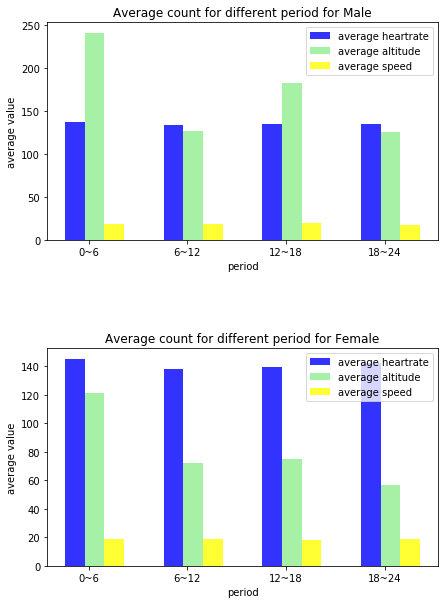

In [722]:
InteractiveShell.ast_node_interactivity = "none"
MaverageHeartRate=[]
MaverageAltitude=[]
MaverageSpeed=[]
for i in range(4):
    MaverageHeartRate.append(mean(dftimeMIN.rdd.map(lambda row: row['MreAvgSptAvgHeartRate'+str(i)]).collect()))
    MaverageAltitude.append(mean(dftimeMIN.rdd.map(lambda row: row['MreAvgSptAvgAltitude'+str(i)]).collect()))
    MaverageSpeed.append(mean(dftimeMIN.rdd.map(lambda row: row['MreAvgSptAvgSpeed'+str(i)]).collect()))
    
FMaverageHeartRate=[]
FMaverageAltitude=[]
FMaverageSpeed=[]
for i in range(4):
    FMaverageHeartRate.append(mean(dftimeFMIN.rdd.map(lambda row: row['FMreAvgSptAvgHeartRate'+str(i)]).collect()))
    FMaverageAltitude.append(mean(dftimeFMIN.rdd.map(lambda row: row['FMreAvgSptAvgAltitude'+str(i)]).collect()))
    FMaverageSpeed.append(mean(dftimeFMIN.rdd.map(lambda row: row['FMreAvgSptAvgSpeed'+str(i)]).collect()))


fig,axes=plt.subplots(2,1,figsize=(7,10))
plt.subplots_adjust(wspace =0, hspace =0.5)

bar_width=0.2
color=['blue','lightgreen','yellow']
timesP=['0~6','6~12','12~18','18~24']

for j in range(2):
    ax=plt.subplot(2,1,j+1)
    plt.sca(ax)       
    if j%2==0:
        nameStr2='M'
        nameStr4='Male'
    else:
        nameStr2='FM'
        nameStr4='Female'    
    for k in range(3):
        if k==0:
            nameStr6='averageHeartRate'
            nameStr7='average heartrate'
        elif k==1:
            nameStr6='averageAltitude'
            nameStr7='average altitude'
        elif k==2:
            nameStr6='averageSpeed'
            nameStr7='average speed'
        showY=locals()[nameStr2+nameStr6]
        plt.bar(x=np.arange(len(timesP))+k*bar_width, height=showY, label=nameStr7, color=color[k], alpha=0.8, width=bar_width)
    plt.xticks(np.arange(len(timesP))+0.7*bar_width, timesP)
    plt.title("Average count for different period for "+nameStr4)
    plt.legend()
    plt.xlabel("period")
    plt.ylabel("average value")

# 5) Classification -- Finding similar guys

In [734]:
InteractiveShell.ast_node_interactivity = "all"
rdd10=df.rdd

def sameday(row):
    if row['heart_rate']!='' and row['speed']!='' and row['altitude']!='':   
        if size(row['heart_rate'])==size(row['speed']) and size(row['heart_rate'])==size(row['altitude']):
            dateValue=[datetime.fromtimestamp(t) for t in row['timestamp']]
#             if dateValue[0].year == dateValue[2].year and dateValue[0].month == dateValue[2].month and dateValue[0].date == dateValue[2].date:
            return Row(id=int(row['id']), gender=row['gender'], timestamp=row['timestamp'], heartrate=row['heart_rate'], speed=row['speed'], altitude=row['altitude'], year=dateValue[0].year, month=dateValue[0].month, day=dateValue[0].day, yearl=dateValue[-1].year, monthl=dateValue[-1].month, dayl=dateValue[-1].day, sport=str(row['sport']),userId=row['userId'])
#             return Row(ratiohtsp=float(vecsp))
rddSd10=rdd10.filter(lambda row: row['speed'] is not None).map(sameday).filter(lambda row: row['year']==row['yearl'] and row['month']==row['monthl'] and row['day']==row['dayl'])
dfSd10=spark.createDataFrame(rddSd10).drop('year').drop('yearl').drop('month').drop('day').drop('monthl').drop('dayl')
# DataFrame(df7.dtypes, columns =['Column Name','Data type'])
# df7.describe().toPandas()
def markWorkout1(row):
    hours=[datetime.fromtimestamp(t).hour for t in row['timestamp']]
    mark=-1
    upIndex=-1
    if hours[0]>=6 and hours[0]<12:
        mark=1
    elif hours[0]>=12 and hours[0]<18:
        mark=2
    elif hours[0]>=18 and hours[0]<24:
        mark=3
    elif hours[0]>=0 and hours[0]<6:
        mark=0
    if mark!=-1:
        perAvgHeatRate=mean(np.array(row['heartrate']))
        perAverageAltitude=mean(np.array(row['altitude']))
        perAverageSpeed=mean(np.array(row['speed']))       
        return Row(id=row['id'], gender=row['gender'], mark=mark, perAvgHeatRate=float(perAvgHeatRate), perAverageAltitude=float(perAverageAltitude), perAverageSpeed=float(perAverageSpeed), sport=str(row['sport']),userId=row['userId'])
    
rddMAvg10=dfSd10.rdd.map(markWorkout1)
dfMAvg10=spark.createDataFrame(rddMAvg10)
DataFrame(dfMAvg10.dtypes, columns =['Column Name','Data type'])
dfMAvg10.describe().toPandas()
dfMAvg10.limit(3).toPandas()

,Column Name,Data type
0,gender,string
1,id,bigint
2,mark,bigint
3,perAverageAltitude,double
4,perAverageSpeed,double
5,perAvgHeatRate,double
6,sport,string
7,userId,bigint


,summary,gender,id,mark,perAverageAltitude,perAverageSpeed,perAvgHeatRate,sport,userId
0,count,31111,31111,31111,31111,31111,31111,31111,31111
1,mean,None,4.096930639432998E8,1.729999035710842,129.37444254443767,20.950533200964298,140.35534691909618,None,5242115.172254187
2,stddev,None,1.529688878415321E8,0.9887179699200304,265.2850452743355,8.500901555657705,16.263120414646806,None,4209486.061659571
3,min,female,9406163,0,-442.7876,0.0,58.908,bike,2358
4,max,unknown,669263168,3,7420.6364,74.8578452,199.892,walk,15326644


,gender,id,mark,perAverageAltitude,perAverageSpeed,perAvgHeatRate,sport,userId
0,male,396826535,2,43.0712,26.162158,152.650,bike,10921915
1,male,392337038,2,35.7248,27.218369,147.710,bike,10921915
2,male,389643739,1,62.4256,26.050774,140.554,bike,10921915


In [776]:
dftmp=dfMAvg10.groupBy(['userId','sport']).agg({'sport':'count','perAverageAltitude':'mean', 'perAverageSpeed':'mean', 'perAvgHeatRate':'mean'})
dftmp.describe().toPandas()
dftmp.limit(3).toPandas()
df10MC=dfMAvg10.groupBy(['userId', 'mark']).count()
df10MC.describe().toPandas()
df10MC.limit(3).toPandas()

,summary,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,count,1258,1258,1258,1258,1258,1258
1,mean,4979837.736883943,None,19.093649492350846,141.70119621820567,24.73052464228935,147.93768799161222
2,stddev,4097194.507488804,None,8.342301210381747,15.774814390646398,42.49179477959104,272.195005901108
3,min,2358,bike,0.0,58.908,1,-80.6044
4,max,15326644,walk,74.8578452,184.66500000000002,494,3471.6469000000006


,userId,sport,avg(perAverageSpeed),avg(perAvgHeatRate),count(sport),avg(perAverageAltitude)
0,775277,walk,6.694675,105.268000,1,106.802800
1,1818822,run,10.720204,161.852364,22,53.181473
2,12200275,bike,28.940755,138.969047,384,386.992311


,summary,userId,mark,count
0,count,1989,1989,1989
1,mean,5194157.737556561,1.7662141779788838,15.641528406234288
2,stddev,4120329.5840665847,0.9812860593946416,26.404428948290747
3,min,2358,0,1
4,max,15326644,3,466


,userId,mark,count
0,1069797,2,7
1,2941284,1,56
2,4057523,1,2


In [812]:
markAll=[0,1,2,3]
def f(valueN): 
    markL=[]
    dic={}
    for item in valueN:
        markL.append(item[0])
    li=list(set(markAll).difference(set(markL)))
    
    for item in valueN:
        dic[item[0]]=item[1]
    for m in li:
        dic[m]=0    
    dicSt=sorted(dic.items(), key=lambda d:d[0])
    markL=[value for key,value in dicSt]   
    return markL

rdd10MCTF=df10MC.rdd.map(lambda row: (row['userId'],(row['mark'],row['count']))).groupByKey().mapValues(f).map(lambda row: Row(userId=row[0], markCt=row[1]))
df10MCTF=spark.createDataFrame(rdd10MCTF)
rdd10MCTF.take(3)

sportAll=sorted(dfMAvg10[['sport']].distinct().rdd.map(lambda row: row['sport']).collect())

def f1(valueN):
    sportDic={}
    averageSpeed={}
    averageHeartRate={}
    averageAltitude={}
    
    sportType=[]
    for item in valueN:
        sportType.append(item[0])
    li=list(set(sportAll).difference(set(sportType)))
        
    for item in valueN:
        sportDic[item[0]]=item[4]
        averageSpeed[item[0]]=round(item[1])
        averageHeartRate[item[0]]=round(item[2])
        averageAltitude[item[0]]=round(item[3])
    
    for sp in li:
        sportDic[sp]=0
        averageSpeed[sp]=0
        averageHeartRate[sp]=0
        averageAltitude[sp]=0
    
    sportDicSt=sorted(sportDic.items(), key=lambda d:d[0])
    sportL=[value for key,value in sportDicSt]
    averageSpeedSt=sorted(averageSpeed.items(), key=lambda d:d[0])
    averageSpeedL=[value for key,value in averageSpeedSt]
    averageHeartRateSt=sorted(averageHeartRate.items(), key=lambda d:d[0])
    averageHeartRateL=[value for key,value in averageHeartRateSt]
    averageAltitudeSt=sorted(averageAltitude.items(), key=lambda d:d[0])
    averageAltitudeL=[value for key,value in averageAltitudeSt]
    
    return sportL, averageSpeedL, averageHeartRateL, averageAltitudeL  
    
rdd10AvgTF=dftmp.rdd.map(lambda row: (row['userId'], (row['sport'], row['avg(perAverageSpeed)'], row['avg(perAvgHeatRate)'], row['avg(perAverageAltitude)'], row['count(sport)']))).groupByKey().mapValues(f1).map(lambda row: Row(userId=row[0], sportCt=row[1][0], averageSpeed=row[1][1], averageHeartRate=row[1][2], averageAltitude=row[1][3]))
rdd10AvgTF.take(3)
df10AvgTF=spark.createDataFrame(rdd10AvgTF)

[Row(markCt=[3, 12, 0, 0], userId=4752000),
 Row(markCt=[1, 0, 1, 0], userId=2175400),
 Row(markCt=[0, 12, 9, 16], userId=2119401)]

[Row(averageAltitude=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1133, 0, 0], averageHeartRate=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0], averageSpeed=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0], sportCt=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0], userId=4752000),
 Row(averageAltitude=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 338, 0, 0], averageHeartRate=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 0, 0], averageSpeed=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0], sportCt=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], userId=2175400),
 Row(averageAltitude=[169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 101, 0, 0], averageHeartRate=[131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 0, 0], averageSpeed=[26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0], sportCt=[23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0], userId=2119401)]

In [822]:
rddgender=dfMAvg10[['userId','gender']].distinct().rdd.filter(lambda row: row['gender']=='male' or row['gender']=='female').map(lambda row: Row(userId=row['userId'],gender=0) if row['gender']=='male' else Row(userId=row['userId'], gender=1))
dfgender=spark.createDataFrame(rddgender)
df10GMCAvgTF=df10MCTF.join(df10AvgTF,'userId','inner').join(dfgender,'userId','inner')
df10GMCAvgTF.describe().toPandas()
df10GMCAvgTF.limit(3).toPandas()

,summary,userId,gender
0,count,737,737
1,mean,5191411.842605156,0.09226594301221167
2,stddev,4120195.218692926,0.2895975371546616
3,min,2358,0
4,max,15326644,1


,userId,markCt,averageAltitude,averageHeartRate,averageSpeed,sportCt,gender
0,4133458,"[0, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",0
1,14320047,"[2, 1, 5, 0]","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
2,2600099,"[0, 43, 68, 11]","[22, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0]","[118, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, ...","[27, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]","[117, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",0


In [890]:
import random
random.seed(50)
rdd10GMCAvgTF=df10GMCAvgTF.rdd
userId=rdd10GMCAvgTF.map(lambda row: row['userId']).collect()
initUsers = random.sample(userId, 5)
centroids = rdd10GMCAvgTF.filter(lambda row: row['userId'] in initUsers).collect()

weightMark=1
weightAltitude=1
weightHeartRate=5
weightSpeed=1.2
weightSport=1
weightGender=3


def assigCent(row):
    distDic={}
    for centroid in centroids:
        disMark=np.sum(np.square(np.array(row['markCt'])-np.array(centroid['markCt'])))
        disAltitude=np.sum(np.square(np.array(row['averageAltitude'])-np.array(centroid['averageAltitude'])))
        disHeartRate=np.sum(np.square(np.array(row['averageHeartRate'])-np.array(centroid['averageHeartRate'])))
        disSpeed=np.sum(np.square(np.array(row['averageSpeed'])-np.array(centroid['averageSpeed'])))
        disSport=np.sum(np.square(np.array(row['sportCt'])-np.array(centroid['sportCt'])))
        disGender=np.sum(np.square(np.array(row['gender'])-np.array(centroid['gender'])))
        distDic[centroid['userId']]=weightMark*disMark+weightAltitude*disAltitude+weightHeartRate*disHeartRate+weightSpeed*disSpeed+weightSport*disSport+weightGender*disGender
    selectedCentroid=min(distDic, key=distDic.get)
    return selectedCentroid

assignedGroup=rdd10GMCAvgTF.map(lambda row: (assigCent(row), row['userId'])).groupByKey().mapValues(list).map(lambda row: row[1]).collect()
firstAssignGroup=assignedGroup

def transfer(bList):
    countSum=[]
    for i in range(len(bList)):
        if i==0:
            countSum=np.array(bList[i])
        else:
            countSum+=np.array(bList[i])
    return countSum/len(bList)

def assigLCent(row):
    distDic={}
    for key, value in centroids.items():
        disMark=np.sum(np.square(np.array(row['markCt'])-np.array(value['markCt'])))
        disAltitude=np.sum(np.square(np.array(row['averageAltitude'])-np.array(value['averageAltitude'])))
        disHeartRate=np.sum(np.square(np.array(row['averageHeartRate'])-np.array(value['averageHeartRate'])))
        disSpeed=np.sum(np.square(np.array(row['averageSpeed'])-np.array(value['averageSpeed'])))
        disSport=np.sum(np.square(np.array(row['sportCt'])-np.array(value['sportCt'])))
        disGender=np.sum(np.square(np.array(row['gender'])-np.array(value['gender'])))
        distDic[key]=weightMark*disMark+weightAltitude*disAltitude+weightHeartRate*disHeartRate+weightSpeed*disSpeed+weightSport*disSport+weightGender*disGender
    selectedCentroid=min(distDic, key=distDic.get)
    return selectedCentroid

def compare(r1, r2):
    if len(r1) != len(r2):
        print(str(len(r1)) + " - " + str(len(r2)))
        return False
    for i in range(len(r1)):
        list_found = False
        for j in range(len(r2)):
            res_list = r1[i]
            a_list = r2[j]            
            if res_list == a_list:
                list_found = True                  
                break
        if not list_found:
#             print(r2[j])
            return False
    return True   

def sortedgroup(groups):
    sortedG=[]
    for group in groups:
        sortedG.append(sorted(group))
    return sortedG
        
times=0
maxIter=20
compResult=False

while compResult==False and times<=maxIter:
    
    newCentroid={}
    i=0
    for group in assignedGroup:
        markList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['markCt']).collect())
        altitudeList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['averageAltitude']).collect())
        heartRateList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['averageHeartRate']).collect())
        speedList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['averageSpeed']).collect())
        sportList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['sportCt']).collect())
        genderList=transfer(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(lambda row: row['gender']).collect())
        newCentroid[i]={'markCt':markList, 'averageAltitude':altitudeList, 'averageHeartRate':heartRateList, 'averageSpeed':speedList, 'sportCt':sportList, 'gender':genderList}
        i+=1

    centroids=newCentroid 

    newAssignedGroup=rdd10GMCAvgTF.map(lambda row: (assigLCent(row), row['userId'])).groupByKey().mapValues(list).map(lambda row: row[1]).collect()
    
    compResult=compare(sortedgroup(assignedGroup), sortedgroup(newAssignedGroup))
    
    if compResult==True or times==maxIter:
            print("---------")
            print(times)
        
    assignedGroup=newAssignedGroup
        
    times+=1

print(firstAssignGroup)
print("---------")
print(assignedGroup)
    

---------
20
[[4133458, 5106976, 6601602, 7017288, 2336853, 9889560, 9221677, 7183572, 14255438, 14370069, 6532016, 6828710, 9345869, 10099521, 6055485, 8785331, 11330346, 1543833, 4836713, 14122572, 8747440, 6963583, 5839886, 1818822, 1912029, 2669847, 3472071, 8107339, 11992223, 1956196, 12406103, 6400833, 12087190, 14083711, 80466, 2464640, 8276277, 1676051, 3992841, 8899244, 1417260, 2232580, 9655659, 3268225, 11825035, 5551642, 10122140, 10536623, 3317373, 1063624, 2175400, 8875079, 431375, 1493217, 4124709, 6162923, 2568526, 6579857, 3167841, 4433918, 4009109, 6716410, 804189, 1009668, 3545637, 4357738, 10779611, 12635957, 2033976, 7710890, 9356728, 2717503, 6216280, 1481127, 13406764, 244128, 5269471, 7038373, 56291, 1882312, 12783742, 407769, 3324472, 1820027, 15326644, 715469, 791908, 2587134, 3824420, 4752000, 4905815, 8070374, 14111843, 200833, 1708694, 6676926, 6961546, 1343759, 7716949, 12175120, 2207788, 7404960, 875281, 5539676, 229190, 2692363, 4938238, 8767606, 6796415

In [892]:
InteractiveShell.ast_node_interactivity = "all"

def reRow(li):
    count=0
    sumV=0
    for i in li:
        if i !=0:
            sumV+=i
            count+=1
    if count !=0:
        value=sumV/count
        return value
    else:
        return 0        

def countAverage(row):
    avgAltitudeSP=reRow(row['averageAltitude'])
    avgHeartRateSP=reRow(row['averageHeartRate'])
    avgSpeedSP=reRow(row['averageSpeed'])
    return Row(useId=row['userId'], markCt=row['markCt'], avgAltitudeSP=float(avgAltitudeSP), avgHeartRateSP=float(avgHeartRateSP), avgSpeedSP=float(avgSpeedSP), sportCt=row['sportCt'], gender=row['gender'])
    
temprdds=[]
for group in firstAssignGroup:
    temprdds.append(spark.createDataFrame(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)))
for group in assignedGroup:
    temprdds.append(spark.createDataFrame(rdd10GMCAvgTF.filter(lambda row: row['userId'] in group).map(countAverage)))
    
for temprdd in temprdds:
    temprdd.toPandas()



,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,196.00,148.00,11.000000,0,"[0, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",4133458
1,165.00,158.00,12.000000,0,"[2, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",5106976
2,66.00,154.00,13.000000,0,"[0, 0, 7, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0]",6601602
3,48.50,134.00,8.500000,0,"[0, 25, 12, 15]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 51, 0, 0]",7017288
4,1651.00,146.00,12.000000,0,"[11, 0, 19, 9]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0]",2336853
5,-1.00,143.00,13.000000,0,"[0, 0, 6, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0]",9889560
6,11.00,148.00,11.000000,0,"[0, 6, 1, 16]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0]",9221677
7,44.00,139.00,11.000000,0,"[0, 2, 3, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0]",7183572
8,344.50,163.00,19.500000,1,"[2, 1, 23, 3]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0]",14255438
9,380.00,141.00,10.000000,0,"[0, 10, 3, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0]",14370069


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,194.0,123.0,26.0,0,"[49, 0, 29, 4]","[82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4403506
1,380.0,124.0,29.0,0,"[30, 0, 17, 14]","[61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4668578
2,23.0,96.5,23.5,0,"[0, 19, 5, 6]","[29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1423027
3,750.0,161.0,28.0,0,"[2, 0, 13, 0]","[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5268649
4,16.0,150.0,20.0,1,"[0, 0, 0, 2]","[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9571309
5,30.0,151.0,19.0,0,"[0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]",10014612
6,6.0,92.0,18.0,0,"[0, 0, 15, 0]","[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",8670360
7,17.0,113.0,25.0,0,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",5844
8,503.0,162.0,22.0,0,"[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11026632
9,436.0,139.5,29.0,0,"[0, 39, 90, 38]","[164, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]",14185532


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,12.0,149.0,28.0,0,"[2, 1, 5, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",14320047
1,44.5,108.5,26.5,0,"[0, 17, 12, 3]","[31, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",95439
2,12.0,154.0,30.0,0,"[24, 0, 68, 40]","[132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4774109
3,259.0,133.0,28.0,0,"[0, 34, 68, 7]","[109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5971071
4,176.0,132.0,23.0,0,"[10, 31, 10, 14]","[65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",538524
5,30.0,143.0,22.0,0,"[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",584087
6,94.0,125.0,24.0,0,"[0, 1, 2, 20]","[23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2740323
7,15.5,136.5,25.0,0,"[0, 11, 21, 35]","[60, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0]",3301823
8,13.0,151.0,27.0,0,"[0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7324715
9,22.5,143.0,24.5,0,"[0, 3, 11, 1]","[12, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10921915


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,38.000000,138.250000,24.000000,0,"[2, 129, 93, 56]","[198, 64, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 16, 0, 0]",510054
1,79.000000,121.333333,21.333333,0,"[0, 156, 127, 42]","[13, 295, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0]",2734298
2,1585.000000,110.000000,25.000000,0,"[0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10982349
3,1090.000000,138.500000,19.000000,0,"[0, 17, 3, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 9, 0, 0, 10, 0, 0]",13564468
4,321.666667,144.666667,21.666667,0,"[0, 32, 57, 9]","[38, 13, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0]",3122949
5,314.666667,139.666667,19.666667,0,"[1, 5, 3, 10]","[3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 14, 0, 0]",1725447
6,1063.000000,142.000000,18.500000,0,"[28, 0, 7, 5]","[38, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]",7790158
7,567.500000,130.000000,25.000000,0,"[0, 24, 8, 2]","[0, 0, 0, 0, 0, 0, 0, 4, 0, 30, 0, 0, 0, 0, 0]",1737182
8,226.500000,143.000000,20.500000,0,"[0, 1, 2, 2]","[4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",3808596
9,728.750000,132.500000,20.500000,0,"[0, 74, 122, 29]","[177, 0, 0, 0, 0, 0, 0, 1, 0, 44, 0, 0, 3, 0, 0]",4399772


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,17.666667,128.333333,21.000000,0,"[0, 43, 68, 11]","[117, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",2600099
1,62.000000,147.500000,21.500000,0,"[0, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",4457345
2,5.000000,149.500000,17.000000,0,"[11, 0, 0, 0]","[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1329120
3,12.000000,131.333333,19.000000,0,"[0, 4, 15, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 17, 0, 0]",2915343
4,15.000000,153.000000,26.500000,0,"[0, 0, 2, 2]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",1048979
5,66.000000,155.000000,20.500000,0,"[0, 3, 3, 2]","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",9484057
6,31.000000,145.500000,14.500000,0,"[0, 0, 6, 0]","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1290773
7,122.500000,130.500000,19.500000,0,"[0, 35, 9, 24]","[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0]",851531
8,29.000000,142.000000,21.500000,0,"[0, 2, 9, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",371523
9,82.000000,136.666667,15.666667,0,"[0, 1, 34, 1]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 31, 0, 0]",2060912


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,196.0,148.000000,11.000000,0,"[0, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",4133458
1,165.0,158.000000,12.000000,0,"[2, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",5106976
2,66.0,154.000000,13.000000,0,"[0, 0, 7, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0]",6601602
3,48.5,134.000000,8.500000,0,"[0, 25, 12, 15]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 51, 0, 0]",7017288
4,-1.0,143.000000,13.000000,0,"[0, 0, 6, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0]",9889560
5,11.0,148.000000,11.000000,0,"[0, 6, 1, 16]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0]",9221677
6,44.0,139.000000,11.000000,0,"[0, 2, 3, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0]",7183572
7,380.0,141.000000,10.000000,0,"[0, 10, 3, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0]",14370069
8,18.0,174.000000,11.000000,0,"[8, 0, 10, 12]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0]",6532016
9,104.0,152.000000,12.000000,0,"[0, 15, 6, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0]",6828710


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,1651.00,146.00,12.0,0,"[11, 0, 19, 9]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 0]",2336853
1,460.00,160.50,17.5,1,"[0, 0, 4, 5]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0]",8785331
2,1349.00,159.00,10.0,0,"[18, 27, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0]",1543833
3,864.00,149.00,9.0,0,"[0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",6963583
4,495.00,146.50,17.5,0,"[0, 3, 8, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 15, 0, 0]",8276277
5,728.75,132.50,20.5,0,"[0, 74, 122, 29]","[177, 0, 0, 0, 0, 0, 0, 1, 0, 44, 0, 0, 3, 0, 0]",4399772
6,568.00,169.00,10.0,1,"[0, 1, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0]",6162923
7,603.50,146.50,19.0,0,"[0, 4, 2, 9]","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0]",6579857
8,942.00,165.00,10.0,0,"[0, 0, 133, 2]","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0]",13406764
9,572.50,138.50,23.0,0,"[0, 37, 49, 27]","[30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 0, 0]",3324472


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,12.000000,149.000000,28.000000,0,"[2, 1, 5, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",14320047
1,194.000000,123.000000,26.000000,0,"[49, 0, 29, 4]","[82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4403506
2,44.500000,108.500000,26.500000,0,"[0, 17, 12, 3]","[31, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",95439
3,380.000000,124.000000,29.000000,0,"[30, 0, 17, 14]","[61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4668578
4,12.000000,154.000000,30.000000,0,"[24, 0, 68, 40]","[132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4774109
5,259.000000,133.000000,28.000000,0,"[0, 34, 68, 7]","[109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5971071
6,176.000000,132.000000,23.000000,0,"[10, 31, 10, 14]","[65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",538524
7,30.000000,143.000000,22.000000,0,"[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",584087
8,94.000000,125.000000,24.000000,0,"[0, 1, 2, 20]","[23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2740323
9,15.500000,136.500000,25.000000,0,"[0, 11, 21, 35]","[60, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0]",3301823


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,1585.0,110.0,25.0,0,"[0, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10982349
1,1090.0,138.5,19.0,0,"[0, 17, 3, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 9, 0, 0, 10, 0, 0]",13564468
2,1828.0,128.0,16.0,0,"[16, 0, 20, 16]","[23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 1]",1676051
3,2242.0,118.0,24.0,0,"[0, 0, 1, 1]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2853238
4,2591.0,152.0,27.0,0,"[1, 0, 1, 0]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4727641
5,1777.5,125.5,17.5,0,"[0, 1, 5, 0]","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]",3082409
6,1377.0,145.5,21.5,0,"[0, 7, 6, 2]","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0]",4226525
7,1820.0,134.0,21.0,0,"[1, 0, 1, 10]","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9299466


,avgAltitudeSP,avgHeartRateSP,avgSpeedSP,gender,markCt,sportCt,useId
0,17.666667,128.333333,21.000000,0,"[0, 43, 68, 11]","[117, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",2600099
1,62.000000,147.500000,21.500000,0,"[0, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",4457345
2,5.000000,149.500000,17.000000,0,"[11, 0, 0, 0]","[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1329120
3,12.000000,131.333333,19.000000,0,"[0, 4, 15, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 17, 0, 0]",2915343
4,38.000000,138.250000,24.000000,0,"[2, 129, 93, 56]","[198, 64, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 16, 0, 0]",510054
5,15.000000,153.000000,26.500000,0,"[0, 0, 2, 2]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0]",1048979
6,66.000000,155.000000,20.500000,0,"[0, 3, 3, 2]","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]",9484057
7,344.500000,163.000000,19.500000,1,"[2, 1, 23, 3]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0]",14255438
8,31.000000,145.500000,14.500000,0,"[0, 0, 6, 0]","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1290773
9,122.500000,130.500000,19.500000,0,"[0, 35, 9, 24]","[52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0]",851531


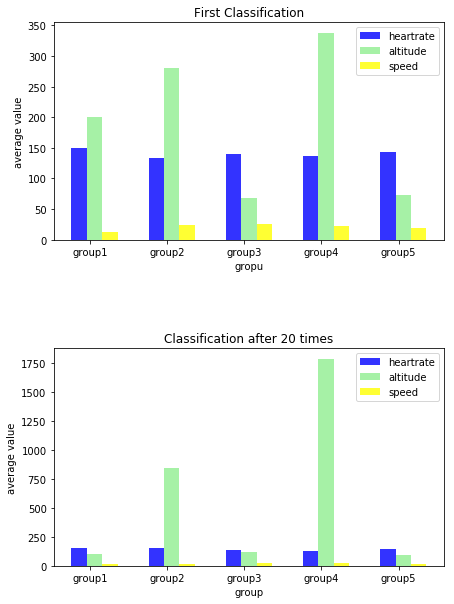

In [896]:
InteractiveShell.ast_node_interactivity = "none"
fig,axes=plt.subplots(2,1,figsize=(7,10))
plt.subplots_adjust(wspace =0.3, hspace =0.5)

bar_width=0.2
color=['blue','lightgreen','yellow']
xShow=['group1','group2','group3','group4','group5']

avgAltitude=[]
avgHeartrate=[]
avgSpeed=[]
avgAltitude1=[]
avgHeartrate1=[]
avgSpeed1=[]
for i in range(len(temprdds)):
    if i<5:
        avgAltitude.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())))
        avgHeartrate.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())))
        avgSpeed.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())))
    else:
        avgAltitude1.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgAltitudeSP']).collect())))
        avgHeartrate1.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgHeartRateSP']).collect())))
        avgSpeed1.append(np.mean(np.array(temprdds[i].rdd.map(lambda row: row['avgSpeedSP']).collect())))
ax=plt.subplot(2,1,1)
plt.sca(ax)    
plt.bar(x=np.arange(len(xShow)), height=avgHeartrate, label='heartrate', color=color[0], alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(xShow))+1*bar_width, height=avgAltitude, label='altitude', color=color[1], alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(xShow))+2*bar_width, height=avgSpeed, label='speed', color=color[2], alpha=0.8, width=bar_width)
plt.xticks(np.arange(len(xShow))+0.7*bar_width, xShow)
plt.title("First Classification")
plt.legend()
plt.xlabel("gropu")
plt.ylabel("average value")

ax=plt.subplot(2,1,2)
plt.sca(ax) 
plt.bar(x=np.arange(len(xShow)), height=avgHeartrate1, label='heartrate', color=color[0], alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(xShow))+1*bar_width, height=avgAltitude1, label='altitude', color=color[1], alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(xShow))+2*bar_width, height=avgSpeed1, label='speed', color=color[2], alpha=0.8, width=bar_width)
plt.xticks(np.arange(len(xShow))+0.7*bar_width, xShow)
plt.title("Classification after 20 times")
plt.legend()
plt.xlabel("group")
plt.ylabel("average value")